In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import glob

In [26]:
BATCH_SIZE = 16
IMG_WIDTH = 128
IMG_HEIGHT = 128
train=False

In [3]:
#Reading and preprocessing images
input_files = glob.glob('data/color_images/*jpg')
target_files = glob.glob('data/color_images/*jpg')
ip_images = []
out_images= []
for i in input_files:
    img = cv2.imread(i)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = np.float32(img)
    img = img/255.0
    ip_images.append(img)

for i in target_files:
    imgg = cv2.imread(i)
    imgg = cv2.cvtColor(imgg,cv2.COLOR_BGR2GRAY)
    imgg = cv2.resize(imgg,(IMG_WIDTH,IMG_HEIGHT))
    imgg = np.float32(imgg)
    imgg = imgg/255.0
    out_images.append(imgg)

ip_images = np.array(ip_images)
out_images = np.array(out_images)
out_images = out_images.reshape(out_images.shape[0],out_images.shape[1],out_images.shape[2],1)

In [4]:
#splitting into training an testiing data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(ip_images,out_images,train_size=0.9)

d:\e\python\tensorflow\tf2.0\tf2.0_3nv\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
OUTPUT_CHANNELS = 1

In [6]:
def downsample(filters,size,apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.,0.02)
    result = tf.keras.models.Sequential()
    result.add(tf.keras.layers.Conv2D(filters,size,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [7]:
down_model = downsample(3, 4)
down_result = down_model(np.expand_dims(x_train[0], 0))
print (down_result.shape)

(1, 64, 64, 3)


In [8]:
def upsample(filters,size,apply_dropout=False):
    initilizer = tf.random_normal_initializer(0.,0.02)
    result = tf.keras.models.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initilizer,use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [9]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [10]:
def Generator():
    down_stack = [
        downsample(64,4,apply_batchnorm=False), #output of thi layer (bs,64,64,64)
        downsample(128,4), #output of thi layer (bs,32,32,128)
        downsample(256,4), #output of thi layer (bs,16,16,256)
        downsample(512,4), #output of thi layer (bs,8,8,512)
        downsample(512,4), #output of thi layer (bs,4,4,512)
        downsample(512,4), #output of thi layer (bs,2,2,512)
        downsample(512,4) #output of thi layer (bs,1,1,512)
    ]
    up_stack = [
        upsample(512,4,apply_dropout=True), #output of thi layer (bs,2,2,1024)
        upsample(512,4,apply_dropout=True), #output of thi layer (bs,4,4,1024)
        upsample(512,4), #output of thi layer (bs,8,8,1024)
        upsample(256,4), #output of thi layer (bs,16,16,512)
        upsample(128,4), #output of thi layer (bs,32,32,256)
        upsample(64,4) #output of thi layer (bs,64,64,128)
    ]
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS,4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') #(bs,128,128,1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x= inputs
    #Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = concat([x,skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

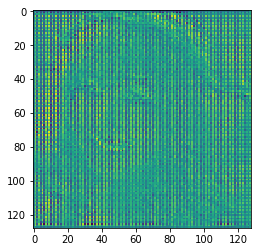

In [11]:
generator = Generator()

gen_output = generator(x_train[0][tf.newaxis,...], training=False)
gen_output[0].shape
plt.imshow(gen_output[0,:,:,0])

In [12]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 6 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, None, None, 1 131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, None, None, 2 525312      sequential_3[0][0]               
______________________________________________________________________________________________

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    inp = tf.keras.layers.Input(shape=[None,None,3],name="input_image")
    tar = tf.keras.layers.Input(shape=[None,None,1],name="target_image")
    x = tf.keras.layers.concatenate([inp,tar]) # (bs,128,128,4)
    down1 = downsample(64,4,False)(x) # (bs,64,64,64)
    down2 = downsample(128,4)(down1) #(bs,32,32,128)
#     down3 = downsample(256,4) #(bs,16,16,256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) #(bs,34,34,128)
    conv = tf.keras.layers.Conv2D(256,4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1) #(bs,31,31,256)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #(bs,33,33,256)
    last = tf.keras.layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zero_pad2) #(bs,30,30,1)
    return tf.keras.Model(inputs=[inp,tar],outputs=last)
    

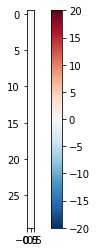

In [14]:
discriminator = Discriminator()
disc_out = discriminator([x_train[0][tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,:,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [15]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, None, None,  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 4 0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, None, None, 6 4096        concatenate_1[0][0]        

In [16]:
LAMBDA = 100

In [17]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [19]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
checkpoint_dir = 'checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

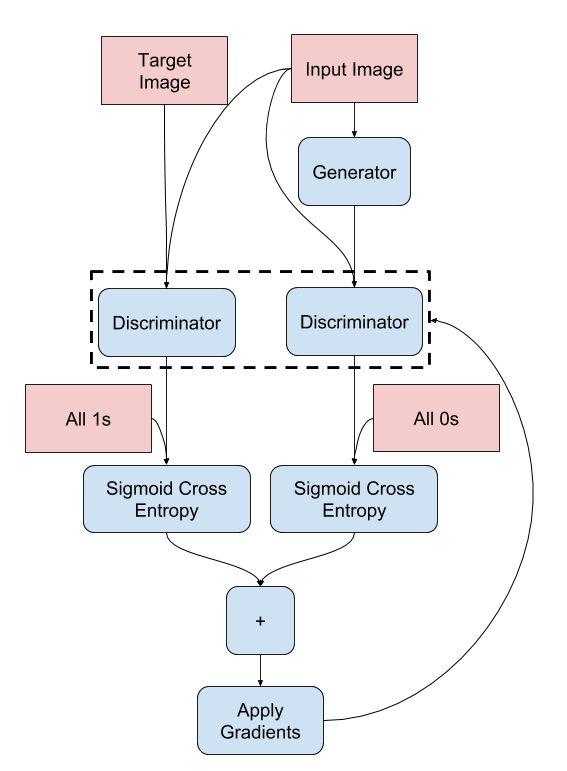

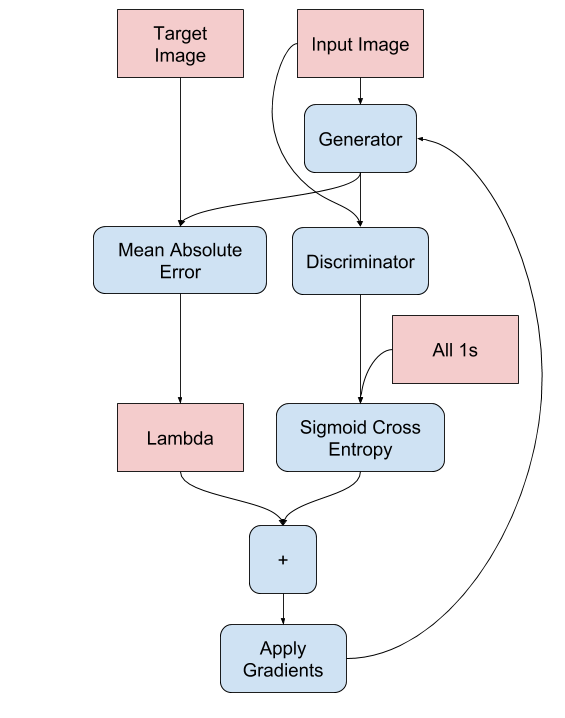

In [22]:
EPOCHS = 200

In [23]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0,:,:,0], prediction[0,:,:,0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
#         plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.imshow(display_list[i],cmap="gray")
        plt.axis('off')
    plt.show()

In [24]:
# @tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)

    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [25]:
def train(inputs=x_train,targets=y_train,test_inputs=x_test,test_outputs=y_test, epochs=50):
    for epoch in range(epochs):
        start = time.time()
        input_image=inputs[epoch*BATCH_SIZE:(epoch*BATCH_SIZE)+BATCH_SIZE]
        target = targets[epoch*BATCH_SIZE:(epoch*BATCH_SIZE)+BATCH_SIZE]

        train_step(input_image, target)

        clear_output(wait=True)
        if epoch < len(x_test):
            inp = np.expand_dims(test_inputs[epoch], 0)
            tar = np.expand_dims(test_outputs[epoch], 0)
        else:
            inp = np.expand_dims(test_inputs[10], 0)
            tar = np.expand_dims(test_outputs[10], 0)
        generate_images(generator, inp, tar)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

In [28]:
if not train:
    # restoring the latest checkpoint in checkpoint_dir
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else:
    train(epochs=200)

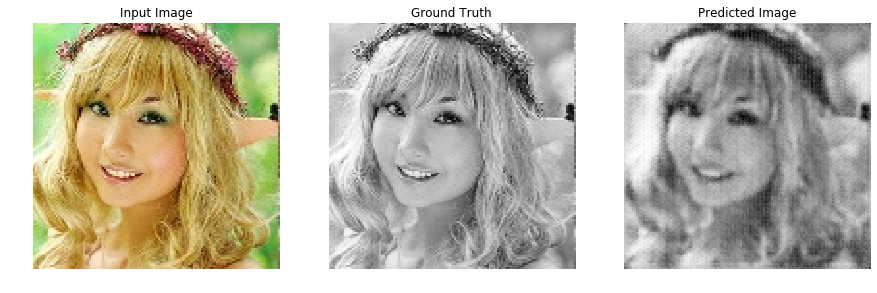

In [29]:
generate_images(generator,np.expand_dims(x_train[0],axis=0),np.expand_dims(y_train[0],axis=0))

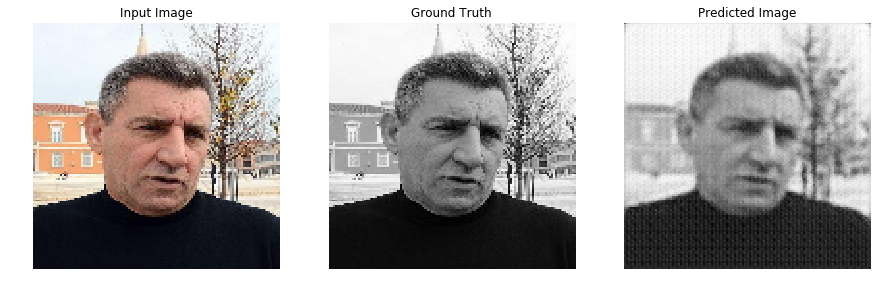

In [30]:
test1 = cv2.imread('test_images/0034_01.jpg')
test1 = cv2.cvtColor(test1,cv2.COLOR_BGR2RGB)
test_tar1 = cv2.cvtColor(test1,cv2.COLOR_BGR2GRAY)
test1 = cv2.resize(test1,(128,128))
test1 = np.float32(test1)
test1 = test1/255.0
# test1 = cv2.resize(test1,(128,128))
test_tar1 = cv2.resize(test_tar1,(128,128))
test_tar1 = np.float32(test_tar1)
test_tar1 = test_tar1/255.0
test_tar1=np.expand_dims(test_tar1,axis=2)
generate_images(generator,np.expand_dims(test1,axis=0),np.expand_dims(test_tar1,axis=0))

In [31]:
prediction = generator(np.expand_dims(test1,axis=0), training=False)

In [32]:
cv2.imshow('img',np.array(prediction[0]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
type(prediction)

tensorflow.python.framework.ops.EagerTensor